In [1]:
from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(return_X_y=True)

### Nested cross-validation

CV 용도 
1. tuning hyper-parameter
2. estimating the generalization performance of a model

hyperparameter를 tuning할 때 CV를 두 번 사용하는 이유를 이해하자

<img src='data/23.png' style='background-color : white' width = '500px' height = '500px'>

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10], "gamma": [.01, .1]}
model_to_tune = SVC()

search = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, n_jobs=2
)
search.fit(data, target)

GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

### gridsearchcv만 적용했을때 구조

<img src='data/24.png' style='background-color : white ; display: block; margin: 0px auto; '  width = '400' height = '400'>

In [3]:
print(f"The best parameters found are: {search.best_params_}")

The best parameters found are: {'C': 0.1, 'gamma': 0.01}


In [4]:
print(f"The mean CV score of the best model is: {search.best_score_:.3f}")

The mean CV score of the best model is: 0.627


> ❗주의사항
>
> we used this score to pick-up the best model. It means that we used knowledge from the test sets (i.e. test scores) to select the hyper-parameter of the model it-self.
>
> this mean score is not a fair estimate of our testing error. Indeed, it can be too optimistic, in particular when running a parameter search on a large grid with many hyper-parameters and many possible values per hyper-parameter. A way to avoid this pitfall is to use a `“nested” cross-validation`.
> 
> <br>

In the following, we will use `an inner cross-validation` corresponding to the previous procedure above to only optimize the hyperparameters. We will also embed this tuning procedure within `an outer cross-validation`, which is dedicated to estimate the testing error of our tuned model.

<br>



In [5]:
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
print(f"The mean score using nested cross-validation is: "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The mean score using nested cross-validation is: 0.627 +/- 0.014


* The reported score is more trustworthy and should be close to production’s expected generalization performance.

### Nested vs non-nested

In [6]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    # For each trial, we use cross-validation splits on independently
    # randomly shuffled data by passing distinct values to the random_state
    # parameter.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                         cv=inner_cv, n_jobs=2)
    model.fit(data, target)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    test_score_nested.append(test_score.mean())

In [8]:
import pandas as pd

### Array나 list를 이런식으로 합칠 수 있군!!
all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

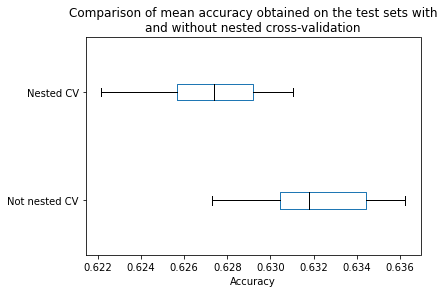

In [9]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")